# [Quick Practice] 
-----
-----
## Post-Analysis Process - Factorization Machine
#### Using xlearn python-wrapper module (https://xlearn-doc.readthedocs.io/en/latest/)

- Using Titanic dataset. (https://www.kaggle.com/c/titanic)
- Original paper (Steffen Rendle, https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf)
- Basic Conceptual Description for FM in korean (http://yamalab.tistory.com/107)

-----
-----
## Step 1 : prepare FM model

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
df1_path = "../dataset/titanic_dataset.csv"
df2_path = "../dataset/titanic_answer.csv"

In [4]:
df1 = pd.read_csv(df1_path)
df2 = pd.read_csv(df2_path)
df = df1.append(df2)

In [5]:
def age_discretize(x):
    if x == np.nan:
        return '10'
    else:
        x = int(x)
        if x < 10:
            return '1'
        elif x < 20 and x >= 10:
            return '2'
        elif x < 30 and x >= 20:
            return '3'
        elif x < 40 and x >= 30:
            return '4'
        elif x < 50 and x >= 40:
            return '5'
        elif x < 60 and x >= 50:
            return '6'
        elif x < 70 and x >= 60:
            return '7'
        elif x < 80 and x >= 70:
            return '8'
        elif x < 90 and x >= 80:
            return '9'
        else:
            return '10'

def fare_discretize(x):
    if x < 10:
        return '1'
    elif x < 20 and x >= 10:
        return '2'
    elif x < 30 and x >= 20:
        return '3'
    elif x < 40 and x >= 30:
        return '4'
    elif x < 50 and x >= 40:
        return '5'
    elif x < 60 and x >= 50:
        return '6'
    elif x < 70 and x >= 60:
        return '7'
    elif x < 80 and x >= 70:
        return '8'
    elif x < 90 and x >= 80:
        return '9'
    else:
        return '10'

In [6]:
df = df[['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare']]
df = df.dropna()

df['sex'] = df['sex'].apply(lambda x: '1' if x == "female" else '0')
df['age'] = df['age'].apply(lambda x: age_discretize(x))
df['fare'] = df['fare'].apply(lambda x: fare_discretize(int(x)))

df['survived'] = df['survived'].astype('str')
df['pclass'] = df['pclass'].astype('str')
df['sibsp'] = df['sibsp'].astype('str')
df['parch'] = df['parch'].astype('str')

In [7]:
# make discretized label to 1~n dict
def make_encoding_label_dict(col_unique):
    encoded_dict = {}
    for idx, unique in enumerate(col_unique):
        encoded_dict[unique] = idx + 1

    return encoded_dict


# get new encoding result
def get_newcode(key, label_dict):
    com_len = len(label_dict)
    if key == np.nan:
        return
    else:
        if key in label_dict:
            return label_dict[key]
        else:
            return com_len + 1

In [8]:
encoded_sibsp_dict = make_encoding_label_dict(df.sibsp.value_counts().index.tolist())
encoded_parch_dict = make_encoding_label_dict(df.parch.value_counts().index.tolist())

In [9]:
df['sibsp'] = df['sibsp'].apply(lambda x: get_newcode(x, encoded_sibsp_dict))
df['parch'] = df['parch'].apply(lambda x: get_newcode(x, encoded_parch_dict))

In [10]:
col_len_dict = {'pclass': 3, 'sex': 1, 'age': 9, 'sibsp': 7, 'parch': 7, 'fare': 10}
col_accum_index_dict = {}
cumulative = 0
for key, value in col_len_dict.items():
    col_accum_index_dict[key] = cumulative
    cumulative = cumulative + value

train_df, test_df = train_test_split(df, test_size=0.2)

In [11]:
txt_file = open('./dataset/train.txt', 'w')
for idx, row in train_df.iterrows():
    vec = []
    label = row['survived']
    vec.append(str(label))
    row = row.drop(labels=['survived'])
    for key, value in row.items():
        if col_len_dict[key] == 1:
            if value != '0':
                col_idx = col_accum_index_dict[key]
                out_val = value
                vec.append(str(col_idx) + ":" + str(out_val))
        else:
            col_idx = col_accum_index_dict[key] + (int(value) - 1)
            out_val = 1
            vec.append(str(col_idx) + ":" + str(out_val))
    txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

In [12]:
txt_file = open('./dataset/test.txt', 'w')
for idx, row in test_df.iterrows():
    vec = []
    label = row['survived']
    vec.append(str(label))
    row = row.drop(labels=['survived'])
    for key, value in row.items():
        if col_len_dict[key] == 1:
            if value != '0':
                col_idx = col_accum_index_dict[key]
                out_val = value
                vec.append(str(col_idx) + ":" + str(out_val))
        else:
            col_idx = col_accum_index_dict[key] + (int(value) - 1)
            out_val = 1
            vec.append(str(col_idx) + ":" + str(out_val))
    txt_file.write("%s\n" % " ".join(vec))
txt_file.close()

-----
-----
## Step 2 : learn FM model

In [19]:
import xlearn as xl

def runner(param, txt_file='./model.txt', model_type='fm'):
    if model_type == "fm":
        model = xl.create_fm()
    else:
        model = xl.create_linear()

    train_path = './dataset/train.txt'
    test_path = './dataset/test.txt'

    model.setTrain(train_path)
    model.setValidate(test_path)

    # Start to train : fit이 seTXTModel 보다 뒤에 있어야만 model.txt가 생성됨.
    model.setTXTModel(txt_file)
    model.fit(param, './model.out')

    # Prediction task
    model.setTest(test_path)
    model.setSigmoid()

    # Start to predict
    model.predict("./model.out", "./output.txt")

In [16]:
# 실험군
txt_file = './abnormal.txt'
param = {'task':'binary',
         'epoch': 3,
         'lr': 0.002,
         'lambda': 0.1,
         'k': 4,
         'metric': 'auc', 
         'opt': 'sgd'}
runner(param, txt_file=txt_file, model_type='fm')

In [17]:
# 대조군
txt_file = './normal.txt'
param = {'task':'binary',
         'epoch': 15,
         'lr': 0.1,
         'lambda': 0.002,
         'k': 8,
         'metric': 'auc',
         'opt': 'adagrad'}
runner(param, txt_file=txt_file, model_type='fm')

In [20]:
# 실험군2
txt_file = './normal_lm.txt'
param = {'task':'binary',
         'epoch': 15,
         'lr': 0.1,
         'lambda': 0.002,
         'k': 8,
         'metric': 'auc',
         'opt': 'adagrad'}
runner(param, txt_file=txt_file, model_type='lm')

-----
-----
## Step 3 : Analyze FM's vectors

#### Compare normal params VS abnormal params

In [21]:
txt_path = './normal.txt'

k = 8
w_0 = {}
w_i = {}
v_ik = {}
with open(txt_path, 'r') as my_file:
    lines = my_file.readlines()
    for line in lines:
        cut_line = line.strip().split(':')
        if cut_line[0] == 'bias':
            w_0[cut_line[0]] = cut_line[1]
        elif "i" in cut_line[0]:
            idx = int(cut_line[0].split('_')[1])
            name = ""
            for key, value in col_accum_index_dict.items():
                if idx >= value:
                    name = key
            w_i[cut_line[0]+"_"+name] = cut_line[1]
        else:
            idx = int(cut_line[0].split('_')[1])
            name = ""
            for key, value in col_accum_index_dict.items():
                if idx >= value:
                    name = key
            v_ik[cut_line[0]+"_"+name] = {}
            v_k = cut_line[1].strip().split(' ')
            for f in range(k):
                v_ik[cut_line[0]+"_"+name][f] = float(v_k[f])

In [22]:
normal_w_0 = w_0
normal_w_i = w_i
normal_v_ik = v_ik

In [23]:
txt_path = './abnormal.txt'

k = 4
w_0 = {}
w_i = {}
v_ik = {}
with open(txt_path, 'r') as my_file:
    lines = my_file.readlines()
    for line in lines:
        cut_line = line.strip().split(':')
        if cut_line[0] == 'bias':
            w_0[cut_line[0]] = cut_line[1]
        elif "i" in cut_line[0]:
            idx = int(cut_line[0].split('_')[1])
            name = ""
            for key, value in col_accum_index_dict.items():
                if idx >= value:
                    name = key
            w_i[cut_line[0]+"_"+name] = cut_line[1]
        else:
            idx = int(cut_line[0].split('_')[1])
            name = ""
            for key, value in col_accum_index_dict.items():
                if idx >= value:
                    name = key
            v_ik[cut_line[0]+"_"+name] = {}
            v_k = cut_line[1].strip().split(' ')
            for f in range(k):
                v_ik[cut_line[0]+"_"+name][f] = float(v_k[f])

In [24]:
abnormal_w_0 = w_0
abnormal_w_i = w_i
abnormal_v_ik = v_ik

-----

In [25]:
normal_v_ik

{'v_0_pclass': {0: 0.400319,
  1: 0.352669,
  2: 0.359188,
  3: 0.642762,
  4: 0.623286,
  5: 0.39631,
  6: 0.462284,
  7: 0.34918},
 'v_1_pclass': {0: 0.199432,
  1: 0.338064,
  2: 0.109668,
  3: 0.297776,
  4: 0.353532,
  5: 0.341881,
  6: 0.273858,
  7: 0.271847},
 'v_2_pclass': {0: -0.180413,
  1: -0.134463,
  2: -0.146963,
  3: -0.235419,
  4: -0.280593,
  5: -0.220825,
  6: -0.172713,
  7: -0.18537},
 'v_3_sex': {0: 0.825431,
  1: 0.733178,
  2: 0.566521,
  3: 1.04348,
  4: 1.09738,
  5: 0.794821,
  6: 0.795387,
  7: 0.615887},
 'v_4_age': {0: 0.185203,
  1: 0.251949,
  2: 0.16626,
  3: 0.338533,
  4: 0.355777,
  5: 0.335893,
  6: 0.251114,
  7: 0.174202},
 'v_5_age': {0: 0.194197,
  1: 0.16021,
  2: 0.15305,
  3: 0.300725,
  4: 0.237944,
  5: 0.24251,
  6: 0.11375,
  7: 0.0910059},
 'v_6_age': {0: 0.164841,
  1: 0.196545,
  2: 0.110489,
  3: 0.156233,
  4: 0.260107,
  5: 0.141504,
  6: 0.192645,
  7: 0.119276},
 'v_7_age': {0: 0.153113,
  1: 0.112446,
  2: 0.171611,
  3: 0.23964

In [26]:
abnormal_v_ik

{'v_0_pclass': {0: 0.00478509, 1: 0.0293586, 2: 0.181161, 3: 0.266345},
 'v_1_pclass': {0: 0.280182, 1: 0.0535095, 2: 0.150008, 3: 0.114339},
 'v_2_pclass': {0: 0.0579785, 1: 0.184763, 2: 0.0168584, 3: 0.13759},
 'v_3_sex': {0: 0.171069, 1: 0.231763, 2: 0.17343, 3: 0.153521},
 'v_4_age': {0: 0.278755, 1: 0.316059, 2: 0.23145, 3: 0.307385},
 'v_5_age': {0: 0.0905827, 1: 0.130135, 2: 0.277736, 3: 0.200771},
 'v_6_age': {0: 0.248811, 1: 0.265027, 2: 0.0456175, 3: 0.237603},
 'v_7_age': {0: 0.267126, 1: 0.0849783, 2: 0.277671, 3: 0.12168},
 'v_8_age': {0: 0.0945298, 1: 0.158157, 2: 0.122372, 3: 0.243639},
 'v_9_age': {0: 0.219531, 1: 0.173384, 2: 0.18909, 3: 0.0298281},
 'v_10_age': {0: 0.197263, 1: 0.139684, 2: 0.194196, 3: 0.273528},
 'v_11_age': {0: 0.161658, 1: 0.25383, 2: 0.0233558, 3: 0.0627722},
 'v_12_age': {0: 0.0738047, 1: 0.257434, 2: 0.0277635, 3: 0.0599174},
 'v_13_sibsp': {0: 0.140818, 1: 0.131212, 2: 0.177868, 3: 0.0689824},
 'v_14_sibsp': {0: 0.128345, 1: 0.120586, 2: 0.265

In [27]:
normal_max_list = []
normal_min_list = []
for feature, vk in normal_v_ik.items():
    vk_max = max(vk.keys(), key=(lambda k: vk[k]))
    vk_min = min(vk.keys(), key=(lambda k: vk[k]))
    normal_max_list.append(vk[vk_max])
    normal_min_list.append(vk[vk_min])
    
abnormal_max_list = []
abnormal_min_list = []
for feature, vk in abnormal_v_ik.items():
    vk_max = max(vk.keys(), key=(lambda k: vk[k]))
    vk_min = min(vk.keys(), key=(lambda k: vk[k]))
    abnormal_max_list.append(vk[vk_max])
    abnormal_min_list.append(vk[vk_min])

-----

#### k'th vector complexity

In [28]:
%matplotlib inline

import matplotlib.pyplot as plt

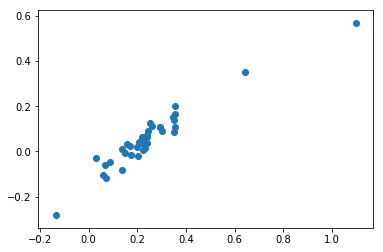

In [29]:
plt.scatter(normal_max_list, normal_min_list)

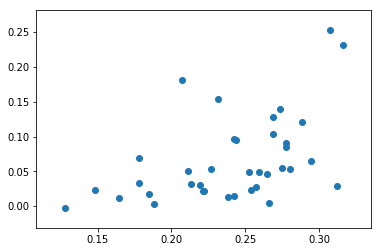

In [30]:
plt.scatter(abnormal_max_list, abnormal_min_list)

-----

#### Linearity

In [53]:
txt_path = './normal.txt'
k = 8
fm_w_i = []
with open(txt_path, 'r') as my_file:
    lines = my_file.readlines()
    for line in lines:
        cut_line = line.strip().split(':')
        if cut_line[0] == 'bias':
            pass
        elif "i" in cut_line[0]:
            fm_w_i.append(float(cut_line[1]))
        else:
            pass
        
txt_path = './normal_lm.txt'
lm_w_i = []
with open(txt_path, 'r') as my_file:
    lines = my_file.readlines()
    for line in lines:
        cut_line = line.strip().split(':')
        if cut_line[0] == 'bias':
            pass
        elif "i" in cut_line[0]:
            lm_w_i.append(float(cut_line[1]))
        else:
            pass

txt_path = './abnormal.txt'
ab_fm_w_i = []
with open(txt_path, 'r') as my_file:
    lines = my_file.readlines()
    for line in lines:
        cut_line = line.strip().split(':')
        if cut_line[0] == 'bias':
            pass
        elif "i" in cut_line[0]:
            ab_fm_w_i.append(float(cut_line[1]))
        else:
            pass

0.933334 0.697534
-0.410232 -0.195406
-1.3791 -0.872573
3.69925 2.19188
0.95069 0.807101
-0.158493 -0.0436003
0.0251544 0.0652274
-0.376571 -0.246276
-0.406419 -0.324781
-0.565122 -0.605323
-1.27856 -1.0971
-0.611346 -0.706398
0.316248 0.456947
-0.0755953 0.067273
0.0920035 -0.00852037
-0.149759 -0.194567
-1.48062 -1.35969
-0.738207 -0.771669
-0.812889 -0.896865
-0.176677 -0.243702
-0.753834 -0.405495
0.465632 0.197116
0.028186 -0.0713094
-0.0357641 -0.0500735
-0.500573 -0.541103
-0.505677 -0.561933
-0.153069 -0.163747
-0.754558 -0.276774
-0.47638 -0.332201
-0.388432 -0.279011
-0.306356 -0.248344
-0.931949 -0.930945
1.03137 0.666009
-0.232937 -0.32495
-0.384167 -0.368437
0.871214 0.784447
0.713645 0.142283


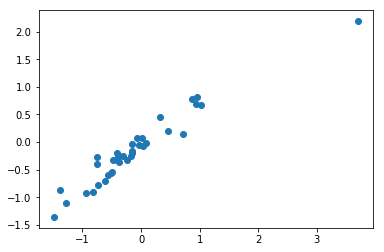

In [58]:
for fm, lm in zip(fm_w_i, lm_w_i):
    print(fm, lm)
plt.scatter(fm_w_i, lm_w_i)

0.0855354 0.697534
-0.0252733 -0.195406
-0.168789 -0.872573
0.19058 2.19188
0.0236748 0.807101
-0.021068 -0.0436003
-0.0600047 0.0652274
-0.0278912 -0.246276
-0.0156629 -0.324781
-0.000845398 -0.605323
-0.0155581 -1.0971
-0.00479632 -0.706398
0.00145513 0.456947
-0.10386 0.067273
0.0282485 -0.00852037
-0.000881696 -0.194567
-0.017722 -1.35969
-0.00563841 -0.771669
-0.00602382 -0.896865
-0.0012319 -0.243702
-0.137248 -0.405495
0.0355722 0.197116
0.014577 -0.0713094
0.00144274 -0.0500735
-0.00346068 -0.541103
-0.00243364 -0.561933
-0.00125652 -0.163747
-0.137602 -0.276774
-0.0384033 -0.332201
-0.00850181 -0.279011
-0.00319256 -0.248344
-0.00836082 -0.930945
0.0232926 0.666009
0.000412743 -0.32495
-0.00173488 -0.368437
0.0117113 0.784447
0.0468903 0.142283


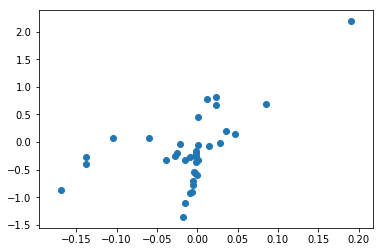

In [59]:
for fm, lm in zip(ab_fm_w_i, lm_w_i):
    print(fm, lm)
plt.scatter(ab_fm_w_i, lm_w_i)

In [65]:
from scipy.stats.stats import pearsonr   
print ("normal situation's linearity :", pearsonr(fm_w_i, lm_w_i))
print ("abnormal situation's linearity :", pearsonr(ab_fm_w_i, lm_w_i))

normal situation's linearity : (0.9651562957302593, 5.793922493363502e-22)
abnormal situation's linearity : (0.5774535984475556, 0.00018251623012776068)
